___

<h1 style="background-color: red; color: black; font-family: cursive; font-size: 400%; text-align: center; border-radius: 50px 50px">Multi-Class Prediction of Cirrhosis Outcomes</h1>

<center> 

![Image large and flat](https://i.imgur.com/gegz2Az.jpeg)

</center>

___

<h1 id="goto0" style="background-color:orangered;font-family:cursive;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Table of Contents</h1>

<div style="font-family: cursive">

0. [Table of Contents](#goto0)

1. [Notebook Description](#goto1)

2. [Loading Libraries](#goto2)

3. [Reading Data Files](#goto3)

4. [Data Exploration](#goto4)

5. [Individuals Modeling](#goto5)

    5a. [Logistic Model](#goto5a)

    5b. [XGB Model](#goto5b)

    5c. [LGBM Model](#goto5c)

    5d. [CAT Model](#goto5c)

    5e. [NN Model](#goto5e)

6. [Voting Meta-Model](#goto6)

7. [Conclusions](#goto7)

</div>

<h1 id="goto1" style="background-color:orangered;font-family:cursive;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Notebook Description</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

<div style="font-family: cursive">

> ### **ENGLISH**

<u>**Goal**</u>: Utilize clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).

**Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Cirrhosis Patient Survival Prediction dataset](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction). Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**For what purpose was the dataset created?**

Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

**Files**

``train.csv`` - the training dataset; Status is the categorical target; C (censored) indicates the patient was alive at N_Days, CL indicates the patient was alive at N_Days due to liver a transplant, and D indicates the patient was deceased at N_Days.

``test.csv`` - the test dataset; your objective is to predict the probability of each of the three Status values, e.g., Status_C, Status_CL, Status_D.

``cirrhosis.csv`` - original dataset.

</div>

---

<div style="font-family: cursive">

> ### **Español**

<u>**Objetivo**</u>: utilizar características clínicas para predecir el estado de supervivencia de pacientes con cirrosis hepática. Los estados de supervivencia incluyen 0 = D (muerte), 1 = C (censurado), 2 = CL (censurado debido a un trasplante de hígado).

**Descripción del conjunto de datos**

El conjunto de datos para esta competencia (tanto de entrenamiento como de prueba) se generó a partir de un modelo de aprendizaje profundo entrenado en el [conjunto de datos de predicción de supervivencia del paciente con cirrosis] (https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction ). Las distribuciones de funciones son cercanas, pero no exactamente iguales, a las del original. Siéntase libre de utilizar el conjunto de datos original como parte de esta competencia, tanto para explorar diferencias como para ver si la incorporación del original en el entrenamiento mejora el rendimiento del modelo.

**¿Con qué propósito se creó el conjunto de datos?**

La cirrosis es el resultado de un daño hepático prolongado, que provoca cicatrices extensas, a menudo debido a afecciones como la hepatitis o el consumo crónico de alcohol. Los datos proporcionados provienen de un estudio de Mayo Clinic sobre cirrosis biliar primaria (CBP) del hígado realizado entre 1974 y 1984.

**Archivos**

``train.csv`` - el conjunto de datos de entrenamiento; El estatus es el objetivo categórico; C (censurado) indica que el paciente estaba vivo en N_Days, CL indica que el paciente estaba vivo en N_Days debido a un trasplante de hígado y D indica que el paciente falleció en N_Days.

``test.csv`` - el conjunto de datos de prueba; su objetivo es predecir la probabilidad de cada uno de los tres valores de Estado, por ejemplo, Estado_C, Estado_CL, Estado_D.

``cirrosis.csv`` - conjunto de datos original.

</div>

---

>Reference: [Walter Reade, Ashley Chow. (2023). Multi-Class Prediction of Cirrhosis Outcomes. Kaggle.](https://www.kaggle.com/competitions/playground-series-s3e26)

>By [Ale uy](https://www.kaggle.com/lasm1984)

<h1 id="goto2" style="background-color:orangered;font-family:cursive;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Loading Libraries</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

#### Basic Tools | Herramientas Básicas

In [1]:
import pandas as pd; pd.set_option("display.max_columns", 30)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns; sns.set(style="whitegrid"); sns.set_palette("husl")
import plotly.express as px

import warnings; warnings.filterwarnings("ignore")

#### Advanced Tools | Herramientas Avanzadas

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import log_loss
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from sklearn.ensemble import VotingClassifier

<h1 id="goto3" style="background-color:orangered;font-family:cursive;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Reading Data Files</h1> 

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

#### Competition Data | Datos de la Competición

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (7905, 20)
The dimension of the test dataset is: (5271, 19)


In [4]:
train.describe().T

count          mean          std      min       25%       50%  \
id             7905.0   3952.000000  2282.121272     0.00   1976.00   3952.00   
N_Days         7905.0   2030.173308  1094.233744    41.00   1230.00   1831.00   
Age            7905.0  18373.146490  3679.958739  9598.00  15574.00  18713.00   
Bilirubin      7905.0      2.594485     3.812960     0.30      0.70      1.10   
Cholesterol    7905.0    350.561923   195.379344   120.00    248.00    298.00   
Albumin        7905.0      3.548323     0.346171     1.96      3.35      3.58   
Copper         7905.0     83.902846    75.899266     4.00     39.00     63.00   
Alk_Phos       7905.0   1816.745250  1903.750657   289.00    834.00   1181.00   
SGOT           7905.0    114.604602    48.790945    26.35     75.95    108.50   
Tryglicerides  7905.0    115.340164    52.530402    33.00     84.00    104.00   
Platelets      7905.0    265.228969    87.465579    62.00    211.00    265.00   
Prothrombin    7905.0     10.629462     0.781735     9.00     10.00     10.60   
Stage          7905.0      3.032511     0.866511     1.00      2.00      3.00   

                    75%       max  
id              5928.00   7904.00  
N_Days          2689.00   4795.00  
Age            20684.00  28650.00  
Bilirubin          3.00     28.00  
Cholesterol      390.00   1775.00  
Albumin            3.77      4.64  
Copper           102.00    588.00  
Alk_Phos        1857.00  13862.40  
SGOT             137.95    457.25  
Tryglicerides    139.00    598.00  
Platelets        316.00    563.00  
Prothrombin       11.00     18.00  
Stage              4.00      4.00

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [6]:
test.describe().T

count          mean          std      min       25%       50%  \
id             5271.0  10540.000000  1521.750965  7905.00   9222.50  10540.00   
N_Days         5271.0   2038.696642  1086.843490    41.00   1234.00   1882.00   
Age            5271.0  18497.756782  3583.898801  9598.00  15730.00  18806.00   
Bilirubin      5271.0      2.600389     3.852395     0.30      0.70      1.10   
Cholesterol    5271.0    352.486435   200.438989   120.00    248.00    299.00   
Albumin        5271.0      3.538071     0.354886     1.96      3.35      3.57   
Copper         5271.0     84.701679    77.542064     4.00     39.00     65.00   
Alk_Phos       5271.0   1811.233314  1935.351492   289.00    823.00   1142.00   
SGOT           5271.0    113.587526    48.964789    26.35     75.00    106.95   
Tryglicerides  5271.0    115.286094    52.602780    33.00     84.00    104.00   
Platelets      5271.0    264.023715    87.584068    62.00    209.00    259.00   
Prothrombin    5271.0     10.632865     0.792711     9.00     10.00     10.60   
Stage          5271.0      3.036995     0.856030     1.00      2.00      3.00   

                    75%       max  
id             11857.50  13175.00  
N_Days          2692.00   4795.00  
Age            20684.00  28650.00  
Bilirubin          3.00     28.00  
Cholesterol      390.00   1775.00  
Albumin            3.77      4.64  
Copper           102.00    588.00  
Alk_Phos        1838.50  13862.40  
SGOT             137.95    457.25  
Tryglicerides    138.00    598.00  
Platelets        317.00    563.00  
Prothrombin       11.00     15.20  
Stage              4.00      4.00

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

#### Separate '`id`' and set the goal '`Status`' | Separar `id` y marcar el objetivo `Status`

In [8]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

TARGET = 'Status'

<h1 id="goto4" style="background-color:orangered;font-family:newtimeroman;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Data Exploration</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

## Dataset Plots | Gráficos de los Datos

#### Categorical Plots | Gráficos de Categóricas

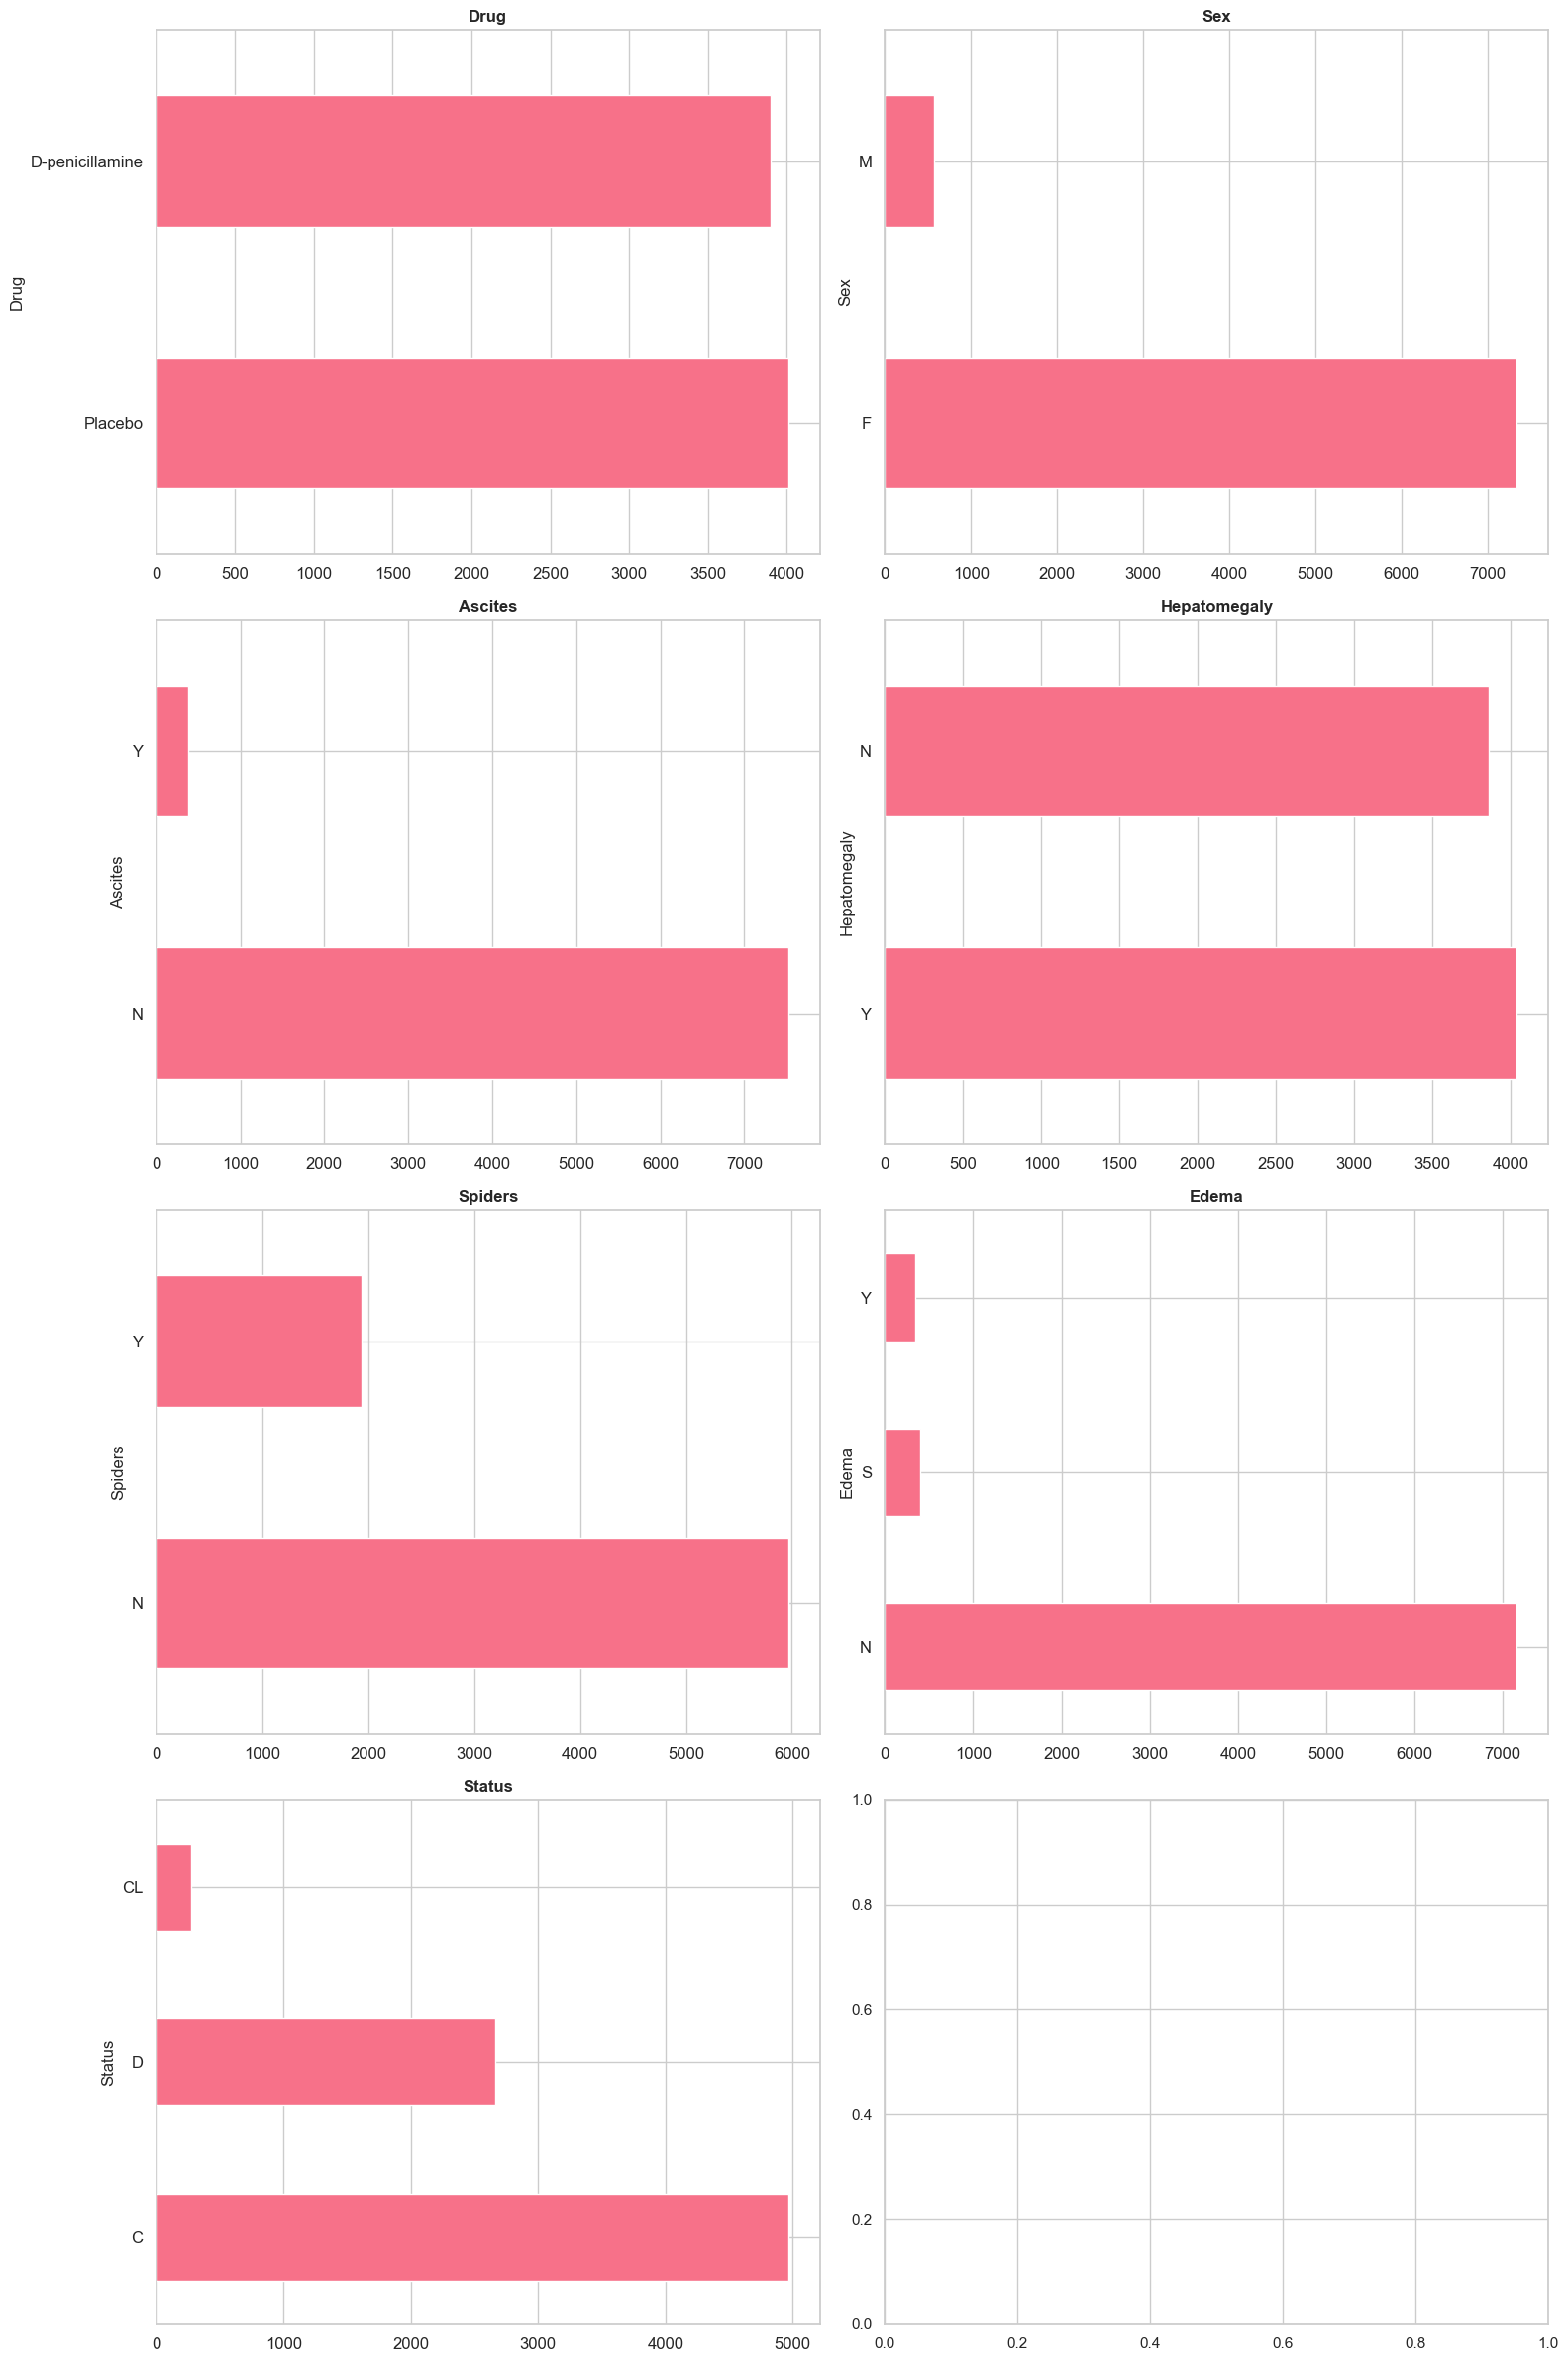

In [9]:
try:    
    categorical_columns = train.select_dtypes('O').columns
    # Calculate the number of categorical columns and rows to organize the plots
    num_columns = len(categorical_columns)
    rows = (num_columns + 1) // 2
    # Create the figure and axes for the plots
    _, ax = plt.subplots(nrows=rows, ncols=2, figsize=(16, rows * 6))
    ax = ax.flat
    # Generate horizontal bar charts for each categorical variable
    for i, col in enumerate(categorical_columns):
        train[col].value_counts().plot.barh(ax=ax[i])
        ax[i].set_title(col, fontsize=12, fontweight="bold")
        ax[i].tick_params(labelsize=12)
    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()
except ValueError:
    print('There are no Categorical Features')

#### Numerical Features Density Function | Función de Densidad de Caracteristicas Numéricas

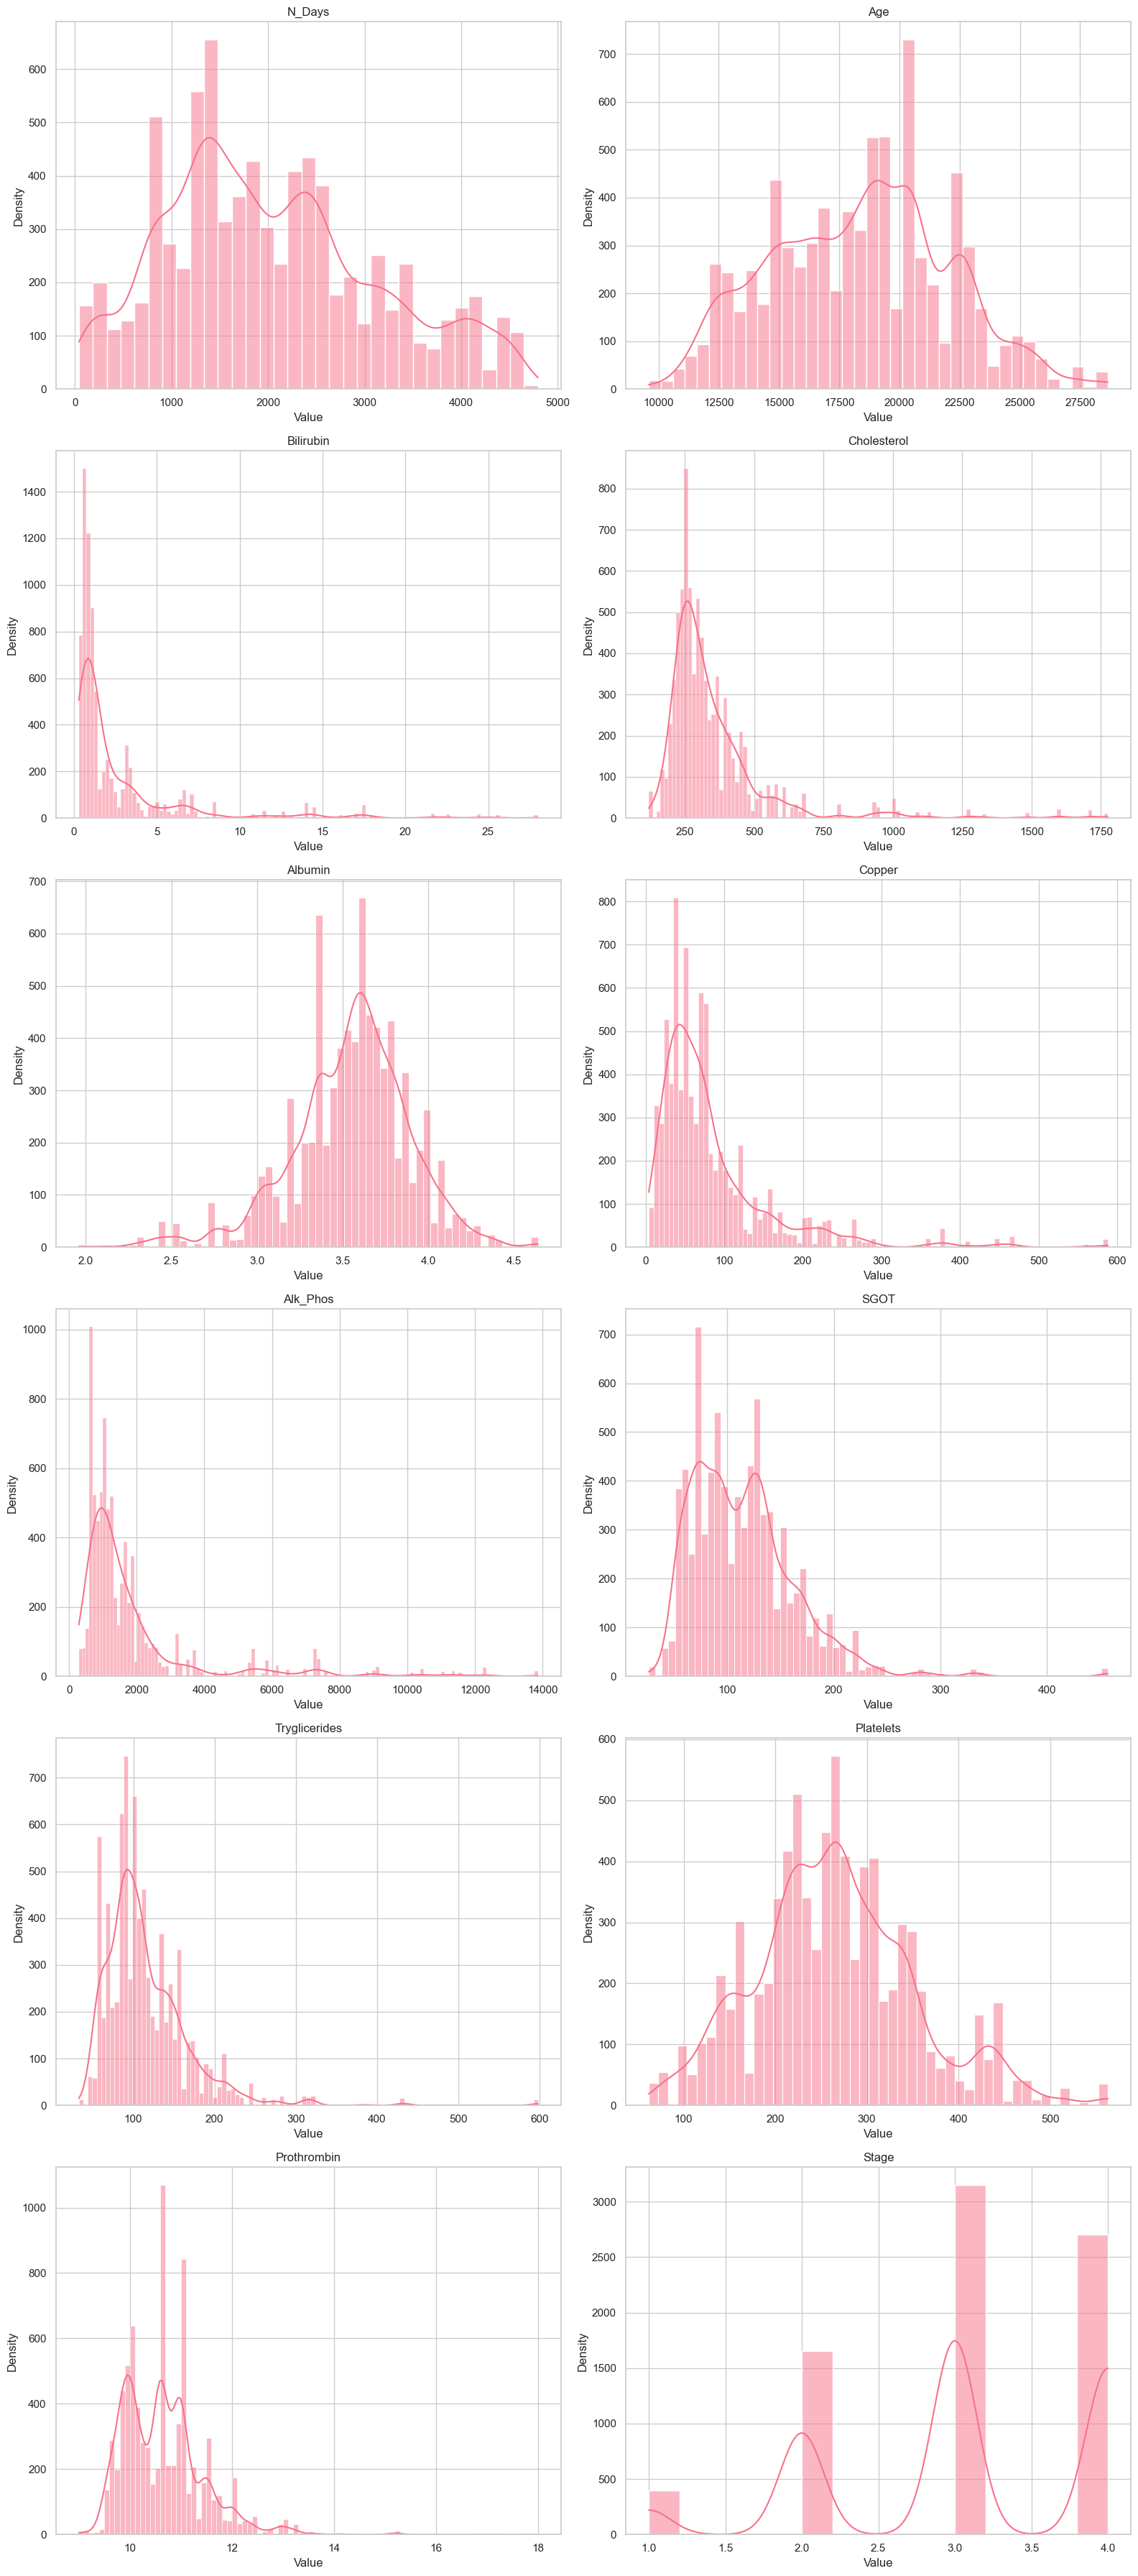

In [10]:
# Get the list of numerical columns in your DataFrame
numeric_columns = train.select_dtypes(include=['float', 'int', 'bool']).columns

# Define the plot size and the number of rows and columns in the grid
num_plots = len(numeric_columns)
rows = (num_plots + 1) // 2  # Calculate the number of rows needed (two plots per row)
cols = 2  # Two plots per row
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

# Iterate through the numerical features and create the density plots
for i, feature_name in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, cols)  # Calculate the current row and column index
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{feature_name}')
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Density')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### Numercal Features Box Plots (Interactive) | Gráficos de Caja de Características Numéricas (Interactivos)

In [11]:
# Melt the DataFrame to have all numerical variables in a single column
df_melted = pd.melt(train.select_dtypes(include=['float', 'int', 'bool']))

# Define a custom color palette
custom_colors = px.colors.qualitative.Plotly  # You can change this to any other palette

# Generate a combined box plot with the custom color palette
fig = px.box(df_melted, x='variable', y='value', color='variable', color_discrete_sequence=custom_colors)
fig.update_layout(title='Box Plots')
fig.show()

#### Numerical Feature Correlations | Correlaciones de Caracteristicas Numéricas

<Axes: >

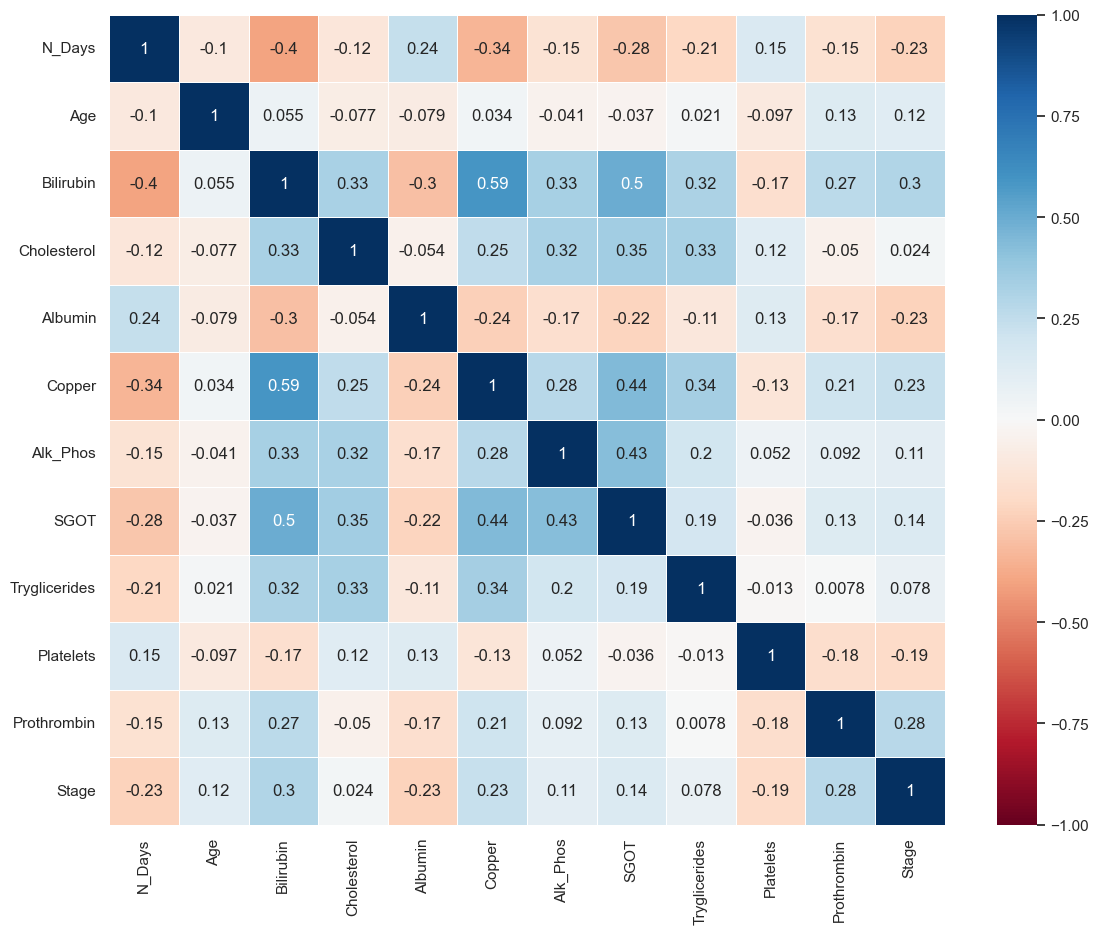

In [12]:
train_ = train.select_dtypes(include=['float', 'int', 'bool']).columns

corr = train[train_].corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.heatmap(corr, linewidth=0.5, annot=True, cmap="RdBu", vmin=-1, vmax=1)

#### Numerical Feature grouping | Grupos de Caracteristicas Numéricas

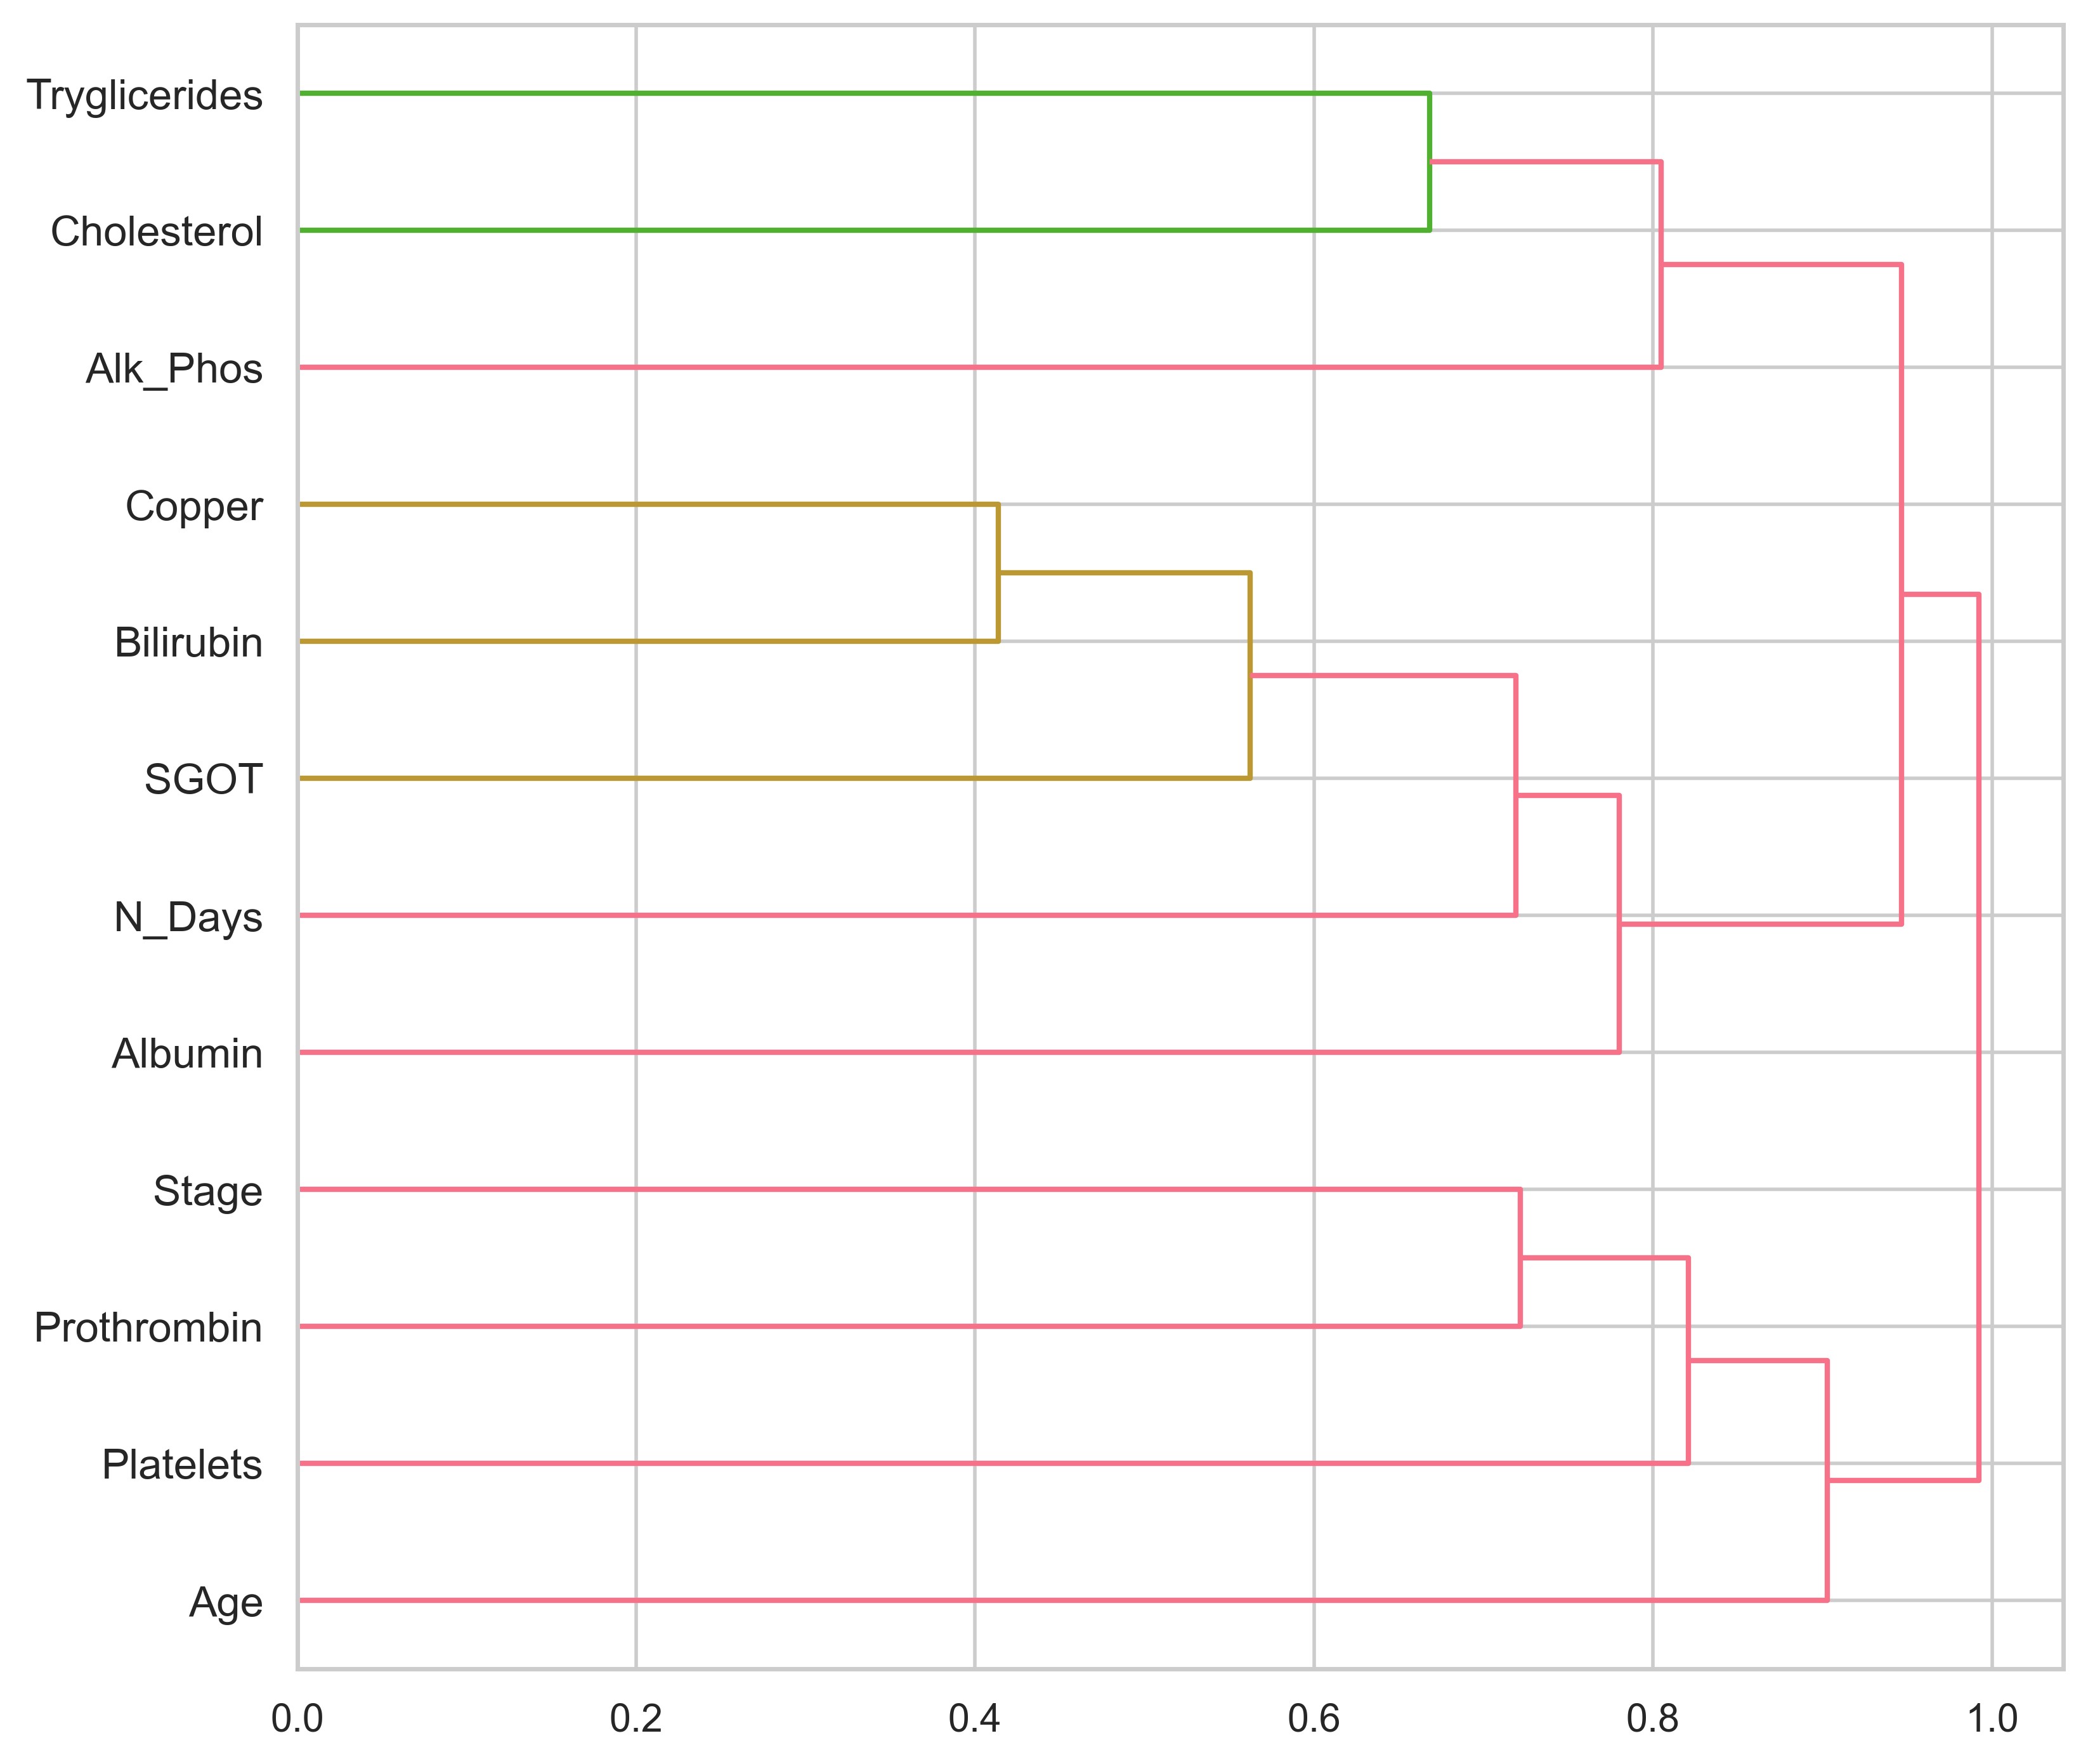

In [13]:
train_ = train.select_dtypes(include=['float', 'int', 'bool']).columns

corr = train[train_].corr(method = "spearman")
link = linkage(squareform(1 - abs(corr)), "complete")
plt.figure(figsize = (8, 8), dpi = 400)
dendro = dendrogram(link, orientation='right', labels=train_)
plt.show()

## Mathematical Analysis | Análisis Matemático

#### Nulls Values | Valores Faltantes

In [14]:
train.isna().sum().sort_values(ascending=False) / train.shape[0] * 100

N_Days           0.0
Albumin          0.0
Stage            0.0
Prothrombin      0.0
Platelets        0.0
Tryglicerides    0.0
SGOT             0.0
Alk_Phos         0.0
Copper           0.0
Cholesterol      0.0
Drug             0.0
Bilirubin        0.0
Edema            0.0
Spiders          0.0
Hepatomegaly     0.0
Ascites          0.0
Sex              0.0
Age              0.0
Status           0.0
dtype: float64

In [15]:
test.isna().sum().sort_values(ascending=False) / test.shape[0] * 100

N_Days           0.0
Drug             0.0
Prothrombin      0.0
Platelets        0.0
Tryglicerides    0.0
SGOT             0.0
Alk_Phos         0.0
Copper           0.0
Albumin          0.0
Cholesterol      0.0
Bilirubin        0.0
Edema            0.0
Spiders          0.0
Hepatomegaly     0.0
Ascites          0.0
Sex              0.0
Age              0.0
Stage            0.0
dtype: float64

#### Duplicate Values | Valores Duplicados

In [16]:
train.duplicated().sum()

0

In [17]:
test.duplicated().sum()

0

#### Distribution of Values in the Target | Distribución de Valores en el Objetivo

In [18]:
train.Status.value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

#### Kurtosis and Skew Analysis | Análisis de Curtosis y Sesgo

* Explanation of Values:
    * Kurtosis:
        * ``Leptokurtic (positive kurtosis)``: Indicates that the tails of the distribution are heavier than they would be in a normal distribution. This implies that there are more extreme values present.
        * ``Platykurtic (negative kurtosis)``: Indicates that the tails of the distribution are lighter than they would be in a normal distribution. This suggests that there are fewer extreme values present.
    * Skew:
        * ``Positive skew``: Indicates that the right tail of the distribution is longer or thicker than the left. Most of the data is concentrated on the left side and there are extreme values on the right side.
        * ``Negative skewness``: Indicates that the left tail of the distribution is longer or thicker than the right. Most of the data is concentrated on the right side and there are extreme values on the left side.
<!--  -->
* Explicación de los Valores:
    * Curtosis:
        * ``Leptocúrtica (positive curtosis)``: Indica que las colas de la distribución son más pesadas de lo que serían en una distribución normal. Esto implica que hay más valores extremos presentes.
        * ``Platicúrtica (negative curtosis)``: Indica que las colas de la distribución son más ligeras de lo que serían en una distribución normal. Esto sugiere que hay menos valores extremos presentes.
    * Sesgo:
        * ``Sesgo positivo``: Indica que la cola derecha de la distribución es más larga o gruesa que la izquierda. La mayoría de los datos se concentran en la parte izquierda y hay valores extremos en la parte derecha.
        * ``Sesgo negativo``: Indica que la cola izquierda de la distribución es más larga o gruesa que la derecha. La mayoría de los datos se concentran en la parte derecha y hay valores extremos en la parte izquierda.

In [19]:
train_ = train.select_dtypes(include=['float', 'int']).columns
test_ = test.select_dtypes(include=['float', 'int']).columns

pd.DataFrame({'train_kurtosis': train[train_].kurtosis(), 'test_kurtosis': test[test_].kurtosis()})

train_kurtosis  test_kurtosis
N_Days              -0.494017      -0.467513
Age                 -0.497382      -0.416881
Bilirubin           12.908824      13.729631
Cholesterol         18.162327      17.695544
Albumin              1.339622       1.157200
Copper              10.212990      11.653368
Alk_Phos            11.599750      11.703609
SGOT                 5.816787       6.840832
Tryglicerides       15.048118      12.672583
Platelets            0.330578       0.347523
Prothrombin          4.288955       2.342642
Stage               -0.525950      -0.537666

In [20]:
pd.DataFrame({'train_skew': train[train_].skew(), 'test_skew': test[test_].skew()})

train_skew  test_skew
N_Days           0.448660   0.429789
Age              0.084091  -0.019643
Bilirubin        3.339695   3.424573
Cholesterol      3.679658   3.668684
Albumin         -0.561150  -0.578913
Copper           2.701736   2.861722
Alk_Phos         3.195558   3.218707
SGOT             1.534806   1.671033
Tryglicerides    2.633921   2.445071
Platelets        0.420048   0.425411
Prothrombin      1.292436   1.120987
Stage           -0.525973  -0.506534

## Apply Transformations | Aplicar Transformaciones

#### Convert categorical to dummy | Convertir categóricas a dummy

In [21]:
Status = train[TARGET]

train = pd.get_dummies(train.drop(columns='Status'), drop_first=True)
train[TARGET] = Status

test = pd.get_dummies(test, drop_first=True)

#### Rename Target Values | Renombrar Valores del Target

In [22]:
names_map = {
 'C': 0,
 'CL': 1,
 'D': 2
}

In [23]:
train[TARGET] = train[TARGET].replace(names_map)

---

> ### Optional | Opcional

#### If the Data Does not Follow a Normal Distribution | Si los Datos no Siguen una Distribución Normal

* Apply Box-Cox | Aplicar Box-Cox

*This transformation also helps us with heteroscedasticity and outliers* | *Esta transformación también nos ayuda con la heterocedasticidad y  valor atípicos*

In [24]:
train_ = train.drop(columns=[TARGET])
numeric_cols = train_.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    train[col], lambda_ = boxcox(train_[col])
    test[col] = boxcox(test[col], lambda_)

#### OR Apply Standard Scaler | O Aplicar Escalador Estándar

In [25]:
# scaler = StandardScaler()

# train_ = train.drop(columns=[TARGET])

# numeric_cols = train_.select_dtypes(include=['int64', 'float64']).columns

# train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

# del(train_)

---

> **Important:** *It is a good idea to regenerate the previous graphs and statistics once the transformations have been applied.* | *Es una buena idea volver a generar los gráficos y estadisticos anteriores una vez aplicadas las transformaciones*

<h1 id="goto5" style="background-color:orangered;font-family:newtimeroman;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Individual Modeling</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

#### Metric Models | Metrica de Modelos

In [26]:
def apply_metrics(y_test, y_pred):
    """
    Calculates metrics.

    Parameters:
        y_test (array-like): True values of the target variable (ground truth).
        y_pred (array-like): Predicted values by the model.

    Returns:
        pandas DataFrame: A DataFrame containing the metrics and their respective values.
    """

    Log_Loss = log_loss(y_test, y_pred)

    metric_df = pd.DataFrame({
        'Metric': ['Log Loss Error'],
        'Value': [Log_Loss]
    })

    return metric_df

#### Create Dependent Variable and Array of Independent Variables | Crear Variable Dependiente y Matriz de Variables Independientes

In [27]:
from sklearn.model_selection import train_test_split


y = train[TARGET]
X = train.drop(columns=[TARGET])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

<h2 id="goto5a" style="background-color:darkorange;font-family:newtimeroman;color:black;font-size:250%;text-align:center;border-radius: 50px 50px;">Logistic Model</h2>

<div style="font-family: cursive">

[Back to Models](#goto5)

</div>

#### Create and train the model | Crear y Entrenar el Modelo

In [28]:
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

#### Predict Test Values | Predecir Valores de Test

In [29]:
y_pred = logistic_model.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [30]:
apply_metrics(y_test, y_pred)

Metric    Value
0  Log Loss Error  0.58077

---

> ### Optional | Opcional

#### More Precise Calibration of Probabilities | Calibración más Precisa de las Probabilidades

In [31]:
calibrated_logistic = CalibratedClassifierCV(logistic_model, method='sigmoid') # isotonic
calibrated_logistic.fit(X_train, y_train)

CalibratedClassifierCV(estimator=LogisticRegression(multi_class='multinomial'))

#### Calibrated Class Probabilities | Probabilidades de Clase Calibradas

In [32]:
calibrated_y_pred = calibrated_logistic.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [33]:
apply_metrics(y_test, calibrated_y_pred)

Metric     Value
0  Log Loss Error  0.589976

#### Graph Importance of Features | Graficar Importancia de las Variables

<Axes: >

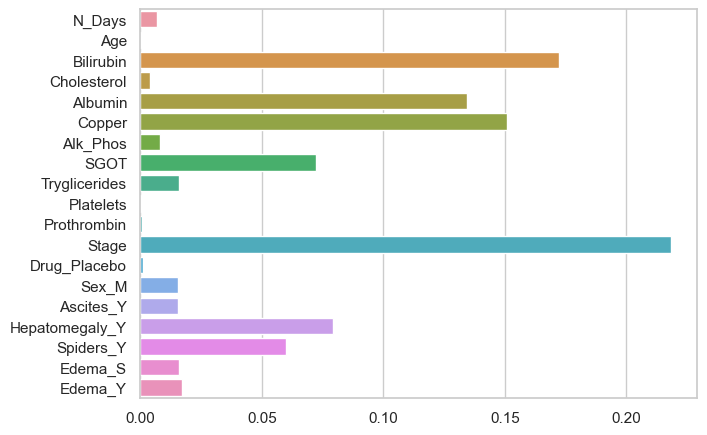

In [34]:
sns.barplot(x = list(abs(logistic_model.coef_[0])), y = list(X.columns))

---

#### Submission and Scoring | Presentación y Puntuación

In [35]:
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

# submission[submission.columns[1:]] = logistic_model.predict_proba(test)
submission[submission.columns[1:]] = calibrated_logistic.predict_proba(test)

In [36]:
submission.to_csv('logistic.csv', index = False)

<p style="color: blue; font-size: 150%"><b>
CONCLUSION: Logistic Model (Box-Cox) is a Good/Bad option.
</b></p>

<p style="color: blue; font-size: 150%"><b>
>> Scoring Log Loss: N/a
</b></p>

<h2 id="goto5b" style="background-color:darkorange;font-family:newtimeroman;color:black;font-size:250%;text-align:center;border-radius: 50px 50px;">Extreme Gradient Boosting Model</h2>

<div style="font-family: cursive">

[Back to Models](#goto5)

</div>

#### Create and train the model | Crear y Entrenar el Modelo

In [37]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3) # multi_logloss y multi:softprob
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

#### Predict Test Values | Predecir Valores de Test

In [38]:
y_pred = xgb_model.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [39]:
apply_metrics(y_test, y_pred)

Metric     Value
0  Log Loss Error  0.494356

---

> ### Optional | Opcional

#### More Precise Calibration of Probabilities | Calibración más Precisa de las Probabilidades

In [40]:
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='sigmoid')
calibrated_xgb.fit(X_train, y_train)

CalibratedClassifierCV(estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_class=3,
                                               num_parallel_tree=None,
                                               objective='multi:softmax', ...))

#### Calibrated Class Probabilities | Probabilidades de Clase Calibradas

In [41]:
calibrated_y_pred = calibrated_xgb.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [42]:
apply_metrics(y_test, calibrated_y_pred)

Metric     Value
0  Log Loss Error  0.460687

#### Graph Importance of Features | Graficar Importancia de las Variables

<Axes: >

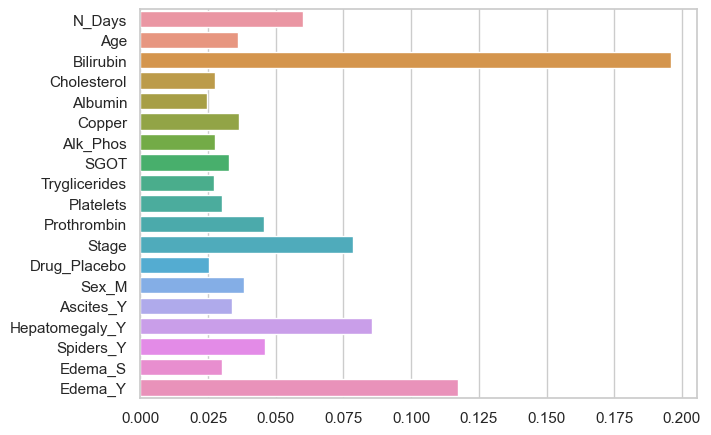

In [43]:
sns.barplot(x = list(xgb_model.feature_importances_), y = list(X.columns))

---

#### Submission and Scoring | Presentación y Puntuación

In [44]:
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

# submission[submission.columns[1:]] = xgb_model.predict_proba(test)
submission[submission.columns[1:]] = calibrated_xgb.predict_proba(test)

In [45]:
submission.to_csv('xgboost.csv', index = False)

<p style="color: green; font-size: 150%"><b>
CONCLUSION: XGB Model (Box-Cox) is a Good option.
</b></p>

<p style="color: green; font-size: 150%"><b>
>> Scoring Log Loss: 0.44352
</b></p>

<h2 id="goto5c" style="background-color:darkorange;font-family:newtimeroman;color:black;font-size:250%;text-align:center;border-radius: 50px 50px;">Light Gradient Boosting Machine</h2>

<div style="font-family: cursive">

[Back to Models](#goto5)

</div>

#### Create and train the model | Crear y Entrenar el Modelo

In [46]:
lgbm_model = LGBMClassifier(objective='multiclass', num_class=3) # multi_logloss
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 19
[LightGBM] [Info] Start training from score -0.461326
[LightGBM] [Info] Start training from score -3.340391
[LightGBM] [Info] Start training from score -1.096225


LGBMClassifier(num_class=3, objective='multiclass')

#### Predict Test Values | Predecir Valores de Test

In [47]:
y_pred = lgbm_model.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [48]:
apply_metrics(y_test, y_pred)

Metric     Value
0  Log Loss Error  0.465983

---

> ### Optional | Opcional

#### More Precise Calibration of Probabilities | Calibración más Precisa de las Probabilidades

In [49]:
calibrated_lgbm = CalibratedClassifierCV(lgbm_model, method='sigmoid')
calibrated_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 19
[LightGBM] [Info] Start training from score -0.461291
[LightGBM] [Info] Start training from score -3.338374
[LightGBM] [Info] Start training from score -1.096506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 19
[LightGBM] [Info] Start training from score -0.461291
[LightGBM] [Info] Start training from score -3.338374
[LightGBM] [Info] Start training from score -1.096506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 secon

CalibratedClassifierCV(estimator=LGBMClassifier(num_class=3,
                                                objective='multiclass'))

#### Calibrated Class Probabilities | Probabilidades de Clase Calibradas

In [50]:
calibrated_y_pred = calibrated_lgbm.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [51]:
apply_metrics(y_test, calibrated_y_pred)

Metric     Value
0  Log Loss Error  0.458001

#### Graph Importance of Features | Graficar Importancia de las Variables

<Axes: >

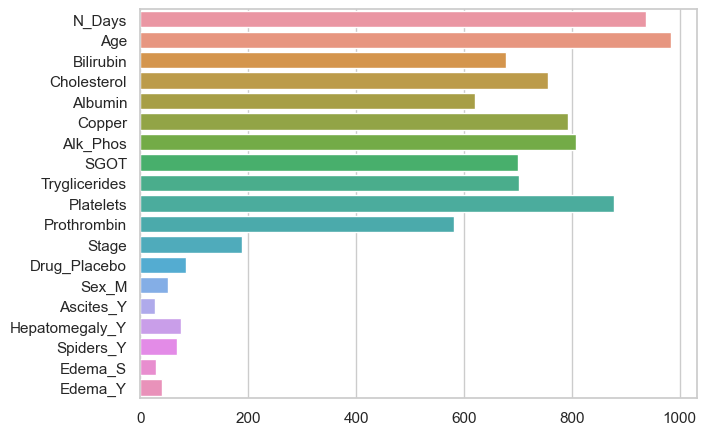

In [52]:
sns.barplot(x = list(lgbm_model.feature_importances_), y = list(lgbm_model.feature_name_))

---

#### Submission and Scoring | Presentación y Puntuación

In [53]:
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

# submission[submission.columns[1:]] = lgbm_model.predict_proba(test)
submission[submission.columns[1:]] = calibrated_lgbm.predict_proba(test)

In [54]:
submission.to_csv('lgbm.csv', index = False)

<p style="color: green; font-size: 150%"><b>
CONCLUSION: LGBM Model (Box-Cox) is a Good option.
</b></p>

<p style="color: green; font-size: 150%"><b>
>> Scoring Log Loss: 0.43799
</b></p>

<h2 id="goto5d" style="background-color:darkorange;font-family:newtimeroman;color:black;font-size:250%;text-align:center;border-radius: 50px 50px;">CAT Boosting Model</h2>

<div style="font-family: cursive">

[Back to Models](#goto5)

</div>

#### Create and train the model | Crear y Entrenar el Modelo

In [55]:
cat_model = CatBoostClassifier(loss_function='MultiClass')
cat_model.fit(X_train, y_train, verbose=False)

#### Predict Test Values | Predecir Valores de Test

In [56]:
y_pred = cat_model.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [57]:
apply_metrics(y_test, y_pred)

Metric     Value
0  Log Loss Error  0.459613

---

> ### Optional | Opcional

#### More Precise Calibration of Probabilities | Calibración más Precisa de las Probabilidades

In [58]:
calibrated_cat = CalibratedClassifierCV(cat_model, method='sigmoid')
calibrated_cat.fit(X_train, y_train, verbose=0)

CalibratedClassifierCV(estimator=<catboost.core.CatBoostClassifier object at 0x00000180FBD089D0>)

#### Calibrated Class Probabilities | Probabilidades de Clase Calibradas

In [59]:
calibrated_y_pred = calibrated_cat.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [60]:
apply_metrics(y_test, calibrated_y_pred)

Metric     Value
0  Log Loss Error  0.456678

#### Graph Importance of Features | Graficar Importancia de las Variables

<Axes: >

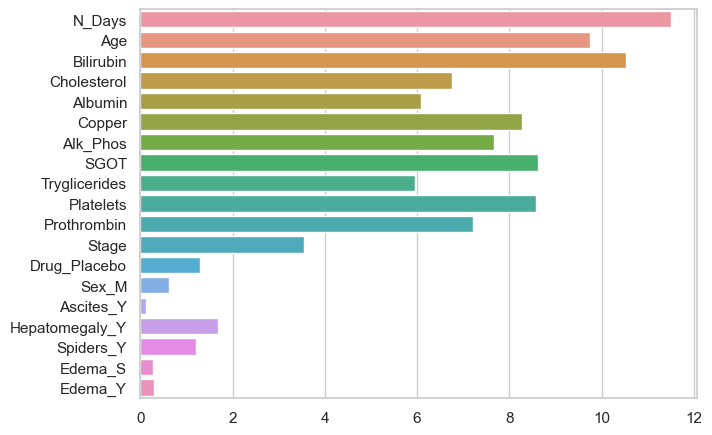

In [61]:
sns.barplot(x = list(cat_model.feature_importances_), y = list(cat_model.feature_names_))

---

#### Submission and Scoring | Presentación y Puntuación

In [62]:
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

# submission[submission.columns[1:]] = cat_model.predict_proba(test)
submission[submission.columns[1:]] = calibrated_cat.predict_proba(test)

In [63]:
submission.to_csv('cat.csv', index = False)

<p style="color: green; font-size: 150%"><b>
CONCLUSION: CAT Model (Box-Cox) is a Good option.
</b></p>

<p style="color: green; font-size: 150%"><b>
>> Scoring Log Loss: 0.43495
</b></p>

<h2 id="goto5e" style="background-color:darkorange;font-family:newtimeroman;color:black;font-size:250%;text-align:center;border-radius: 50px 50px;">Neural Network Model</h2>

<div style="font-family: cursive">

[Back to Models](#goto5)

</div>

>NOTE: Create the custom neural network meta-model based in this [Great Job!](https://www.kaggle.com/code/larjeck/regression-with-a-mohs-hardness-dataset-optimal)

#### Generate One Hot Encode on the Target | Generar "One Hot Encode" en el Target

In [64]:
encoder = OneHotEncoder(sparse=False, categories='auto')
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

These **callbacks** are used to improve the performance and stability of training deep learning models. ``EarlyStopping`` prevents overfitting by stopping training when the validation metric stops improving, ``ReduceLROnPlateau`` dynamically adjusts the learning rate for more stable training and ``TerminateOnNaN`` stops training if there are numerical problems.

Estas **devoluciones de llamada** se utilizan para mejorar el rendimiento y la estabilidad del entrenamiento de modelos de aprendizaje profundo. ``EarlyStopping`` previene el sobreajuste al detener el entrenamiento cuando la métrica de validación deja de mejorar, ``ReduceLROnPlateau`` ajusta dinámicamente la tasa de aprendizaje para un entrenamiento más estable y ``TerminateOnNaN`` detiene el entrenamiento si hay problemas numéricos.

In [65]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [66]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.00001, input_shape=(len(X.columns), )),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5, beta_2=0.999, epsilon=1e-07),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

nn_model = create_model()

nn_model.fit(X.astype('float32'), y_encoded.astype('float32'),
            epochs=200,
            callbacks=callbacks_list,
            validation_split=0.1)

Epoch 1/200
223/223 [==============================] - 3s 4ms/step - loss: 0.5575 - accuracy: 0.7870 - val_loss: 0.6149 - val_accuracy: 0.7547 - lr: 0.0130
Epoch 2/200
223/223 [==============================] - 1s 3ms/step - loss: 0.5251 - accuracy: 0.8012 - val_loss: 0.5219 - val_accuracy: 0.7990 - lr: 0.0130
Epoch 3/200
223/223 [==============================] - 1s 3ms/step - loss: 0.5222 - accuracy: 0.8001 - val_loss: 0.5035 - val_accuracy: 0.8028 - lr: 0.0130
Epoch 4/200
223/223 [==============================] - 1s 3ms/step - loss: 0.5134 - accuracy: 0.7997 - val_loss: 0.5043 - val_accuracy: 0.8053 - lr: 0.0130
Epoch 5/200
223/223 [==============================] - 1s 3ms/step - loss: 0.5171 - accuracy: 0.8010 - val_loss: 0.5169 - val_accuracy: 0.8003 - lr: 0.0130
Epoch 6/200
223/223 [==============================] - 1s 3ms/step - loss: 0.5077 - accuracy: 0.8056 - val_loss: 0.5057 - val_accuracy: 0.8104 - lr: 0.0130
Epoch 7/200
223/223 [==============================] - 1s 3ms/st

#### Predict Test Values | Predecir Valores de Test

In [67]:
y_pred = nn_model.predict(X_test.astype('float32'))

25/25 [==============================] - 0s 2ms/step


#### Measure Performance | Medir el Rendimiento

In [68]:
apply_metrics(y_test_encoded, y_pred)

Metric     Value
0  Log Loss Error  0.456913

---

### Submission and Scoring | Presentación y Puntuación

In [69]:
# Test a submission
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

submission[submission.columns[1:]] = nn_model.predict(test.astype('float32'))

165/165 [==============================] - 0s 2ms/step


In [70]:
submission.to_csv('nn.csv', index = False)

<p style="color:orange;font-size:150%"><b>
CONCLUSION: NN Model (Box-Cox) is a Regular option.
</b></p>

<p style=color:orange;font-size:150%><b>
* Scoring Log Loss: 0.51842
</b></p>

<h1 id="goto6" style="background-color:orangered;font-family:newtimeroman;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Voting Meta-Model</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

#### Create a ``VotingClassifier`` meta estimator with the above models without the logistic and NN model. | Crea un meta estimador ``VotingClassifier`` con los modelos anteriores sin los modelos logístico y NN.

#### Create and train the model | Crear y Entrenar el Modelo

In [71]:
voting_clf = VotingClassifier(estimators=[('xgb', calibrated_xgb), ('lgb', calibrated_lgbm), ('cat', calibrated_cat)], voting='soft', verbose=False) # ('log', logistic_model)
voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 19
[LightGBM] [Info] Start training from score -0.461291
[LightGBM] [Info] Start training from score -3.338374
[LightGBM] [Info] Start training from score -1.096506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 19
[LightGBM] [Info] Start training from score -0.461291
[LightGBM] [Info] Start training from score -3.338374
[LightGBM] [Info] Start training from score -1.096506
[LightGBM] [Info] Auto-choosing col-

VotingClassifier(estimators=[('xgb',
                              CalibratedClassifierCV(estimator=XGBClassifier(base_score=None,
                                                                             booster=None,
                                                                             callbacks=None,
                                                                             colsample_bylevel=None,
                                                                             colsample_bynode=None,
                                                                             colsample_bytree=None,
                                                                             early_stopping_rounds=None,
                                                                             enable_categorical=False,
                                                                             eval_metric=None,
                                                                             feature_types=None,
                                                                             gamma=None,
                                                                             gpu_id=None,
                                                                             grow_policy=None,
                                                                             importance_type=None,
                                                                             interac...
                                                                             min_child_weight=None,
                                                                             missing=nan,
                                                                             monotone_constraints=None,
                                                                             n_estimators=100,
                                                                             n_jobs=None,
                                                                             num_class=3,
                                                                             num_parallel_tree=None,
                                                                             objective='multi:softmax', ...))),
                             ('lgb',
                              CalibratedClassifierCV(estimator=LGBMClassifier(num_class=3,
                                                                              objective='multiclass'))),
                             ('cat',
                              CalibratedClassifierCV(estimator=<catboost.core.CatBoostClassifier object at 0x00000180FBD089D0>))],
                 voting='soft')

#### Predict Test Values | Predecir Valores de Test

In [72]:
y_pred = voting_clf.predict_proba(X_test)

#### Measure Performance | Medir el Rendimiento

In [73]:
apply_metrics(y_test, y_pred)

Metric     Value
0  Log Loss Error  0.455322

---

### Submission and Scoring | Presentación y Puntuación

In [74]:
# Test a submission
submission = pd.read_csv('sample_submission.csv')

submission[submission.columns[0]] = test_id

submission[submission.columns[1:]] = voting_clf.predict_proba(test)

In [75]:
submission.to_csv('cls.csv', index = False)

<p style=color:green;font-size:150%><b>
CONCLUSION: Voting meta-model (Box-Cox) is a Good option.
</b></p>

<p style=color:green;font-size:150%><b>
* Scoring Log Loss: 0.43412
</b></p>

<h1 id="goto7" style="background-color:orangered;font-family:newtimeroman;color:black;font-size:350%;text-align:center;border-radius: 50px 50px;">Conclusions</h1>

<div style="font-family: cursive">

[Back to Table of Contents](#goto0)

</div>

<div style="color: OrangeRed; font-family: cursive"><b>

The Best Result:

* The Voting Model (with Box-Cox data transformation) presents the best performance
  
It Might be Interesting:

* Apply Class Balancing to 'CL'
* Customize Model Hyperparameters
* Try a Special Treatment for the 'Age' Feature

</b></div>